In [1]:
# Data-handling imports
import pandas as pd
import numpy as np

# Unsupervised learning imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Other libraries
import matplotlib.pyplot as plt
import plotstyle
import spacy
nlp = spacy.load('en')

# Options
seed = 5777

# Read in data

In [2]:
essays = pd.read_csv(f"../data_private/essays_cleaned_target.csv")

# Cluster analyses

## $k$-Means on document vectors

### Run

In [3]:
vs = [nlp(doc).vector for doc in essays["essay"]]
km_vec = KMeans(n_clusters=4, random_state=seed)
km_vec.fit(vs)

KMeans(n_clusters=4, random_state=5777)

### Evaluate

In [4]:
sil_vec = silhouette_score(vs, km_vec.labels_)

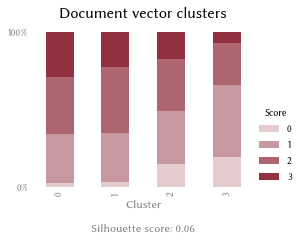

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plotstyle.setup("Document vector clusters", "Cluster", "", xformat="{x:,.0f}", ax=ax)

df = pd.DataFrame({
    "score": essays["score"],
    "cluster": km_vec.labels_,
    "count": 1
})
totals = df.groupby(["cluster"]).count()
df = df.groupby(["cluster", "score"]).count().reset_index()
df["cluster_total"] = df["cluster"].map(totals["score"])
df["prop"] = df["count"] / df["cluster_total"]

df.pivot("cluster", "score", "prop").plot.bar(stacked=True, ax=ax,
                                              color=[
                                                  "#E4CCCF",
                                                  "#C898A0",
                                                  "#AD6570",
                                                  "#913140"
                                              ]);
ax.set_xlabel("Cluster\n\nSilhouette score: {:.2f}".format(sil_vec))
ax.set_yticklabels(["0%", "", "", "", "", "100%"])
plt.legend([0,1,2,3], framealpha=1, frameon=False, loc=(1,0), title="Score")
plt.savefig("../graphs/cluster-vec.svg", transparent=True, bbox_inches="tight")

## $k$-Means on metadata

### Run

In [6]:
meta_cols = [
    "tokens",
    "types",
    "sent_len",
    "word_len",
    "freq",
    "semicolons",
    "link_words",
    "pps",
    "max_depth"
]
km_meta = KMeans(n_clusters=4, random_state=seed)
km_meta.fit(essays[meta_cols])

KMeans(n_clusters=4, random_state=5777)

### Evaluate

In [7]:
sil_meta = silhouette_score(essays[meta_cols], km_meta.labels_)

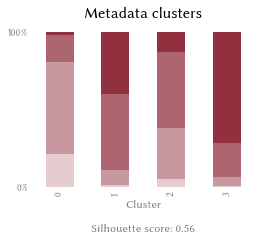

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plotstyle.setup("Metadata clusters", "Cluster", "", xformat="{x:,.0f}", ax=ax)

df = pd.DataFrame({
    "score": essays["score"],
    "cluster": km_meta.labels_,
    "count": 1
})
totals = df.groupby(["cluster"]).count()
df = df.groupby(["cluster", "score"]).count().reset_index()
df["cluster_total"] = df["cluster"].map(totals["score"])
df["prop"] = df["count"] / df["cluster_total"]

df.pivot("cluster", "score", "prop").plot.bar(stacked=True, ax=ax,
                                              color=[
                                                  "#E4CCCF",
                                                  "#C898A0",
                                                  "#AD6570",
                                                  "#913140"
                                              ]);
ax.set_xlabel("Cluster\n\nSilhouette score: {:.2f}".format(sil_meta))
ax.set_yticklabels(["0%", "", "", "", "", "100%"])
#plt.legend([0,1,2,3], framealpha=1, frameon=False, loc=(1,0), title="Score")
ax.get_legend().remove()
plt.savefig("../graphs/cluster-meta.svg", transparent=True, bbox_inches="tight")

# Write out data

In [9]:
# Add metadata clusters, which may be of interest when modeling
essays["cluster"] = km_meta.labels_
essays.to_csv("../data_private/essays_cleaned_target.csv", index=False)